## Load Libraries

In [8]:
import splitfolders
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modeling
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Model Inference
from tensorflow.keras.preprocessing.image import load_img, img_to_array


## Load Dataset

In [9]:
splitfolders.ratio("rice_disease_dataset", output="output",
    seed=1337, ratio=(.7, .3), group_prefix=None, move=False) 

In [10]:
train = 'output/train'
val = 'output/val'

## EDA

In [11]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

2 folder and 0 images in output
3 folder and 0 images in output\train
0 folder and 64 images in output\train\blast
0 folder and 64 images in output\train\blight
0 folder and 64 images in output\train\tungro
3 folder and 0 images in output\val
0 folder and 24 images in output\val\blast
0 folder and 24 images in output\val\blight
0 folder and 24 images in output\val\tungro


In [12]:
train_data = image_dataset_from_directory(train)
val_data = image_dataset_from_directory(val)

Found 192 files belonging to 3 classes.
Found 72 files belonging to 3 classes.


In [13]:
class_names = train_data.class_names
print(class_names)

['blast', 'blight', 'tungro']


### Example of Images in Each Class

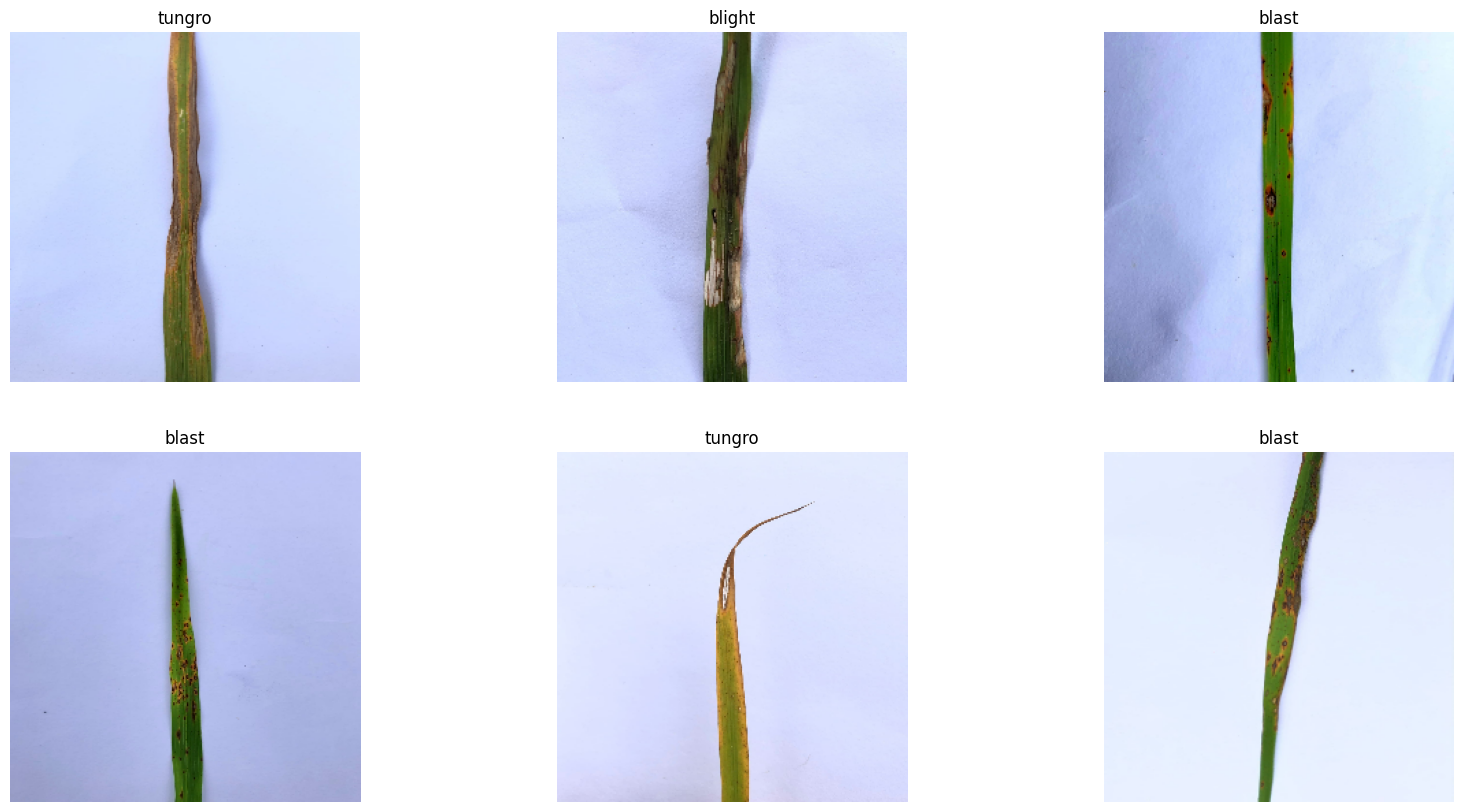

In [14]:
plt.figure(figsize=(20, 10))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Example How Data Augmented Looks Like

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4),
])

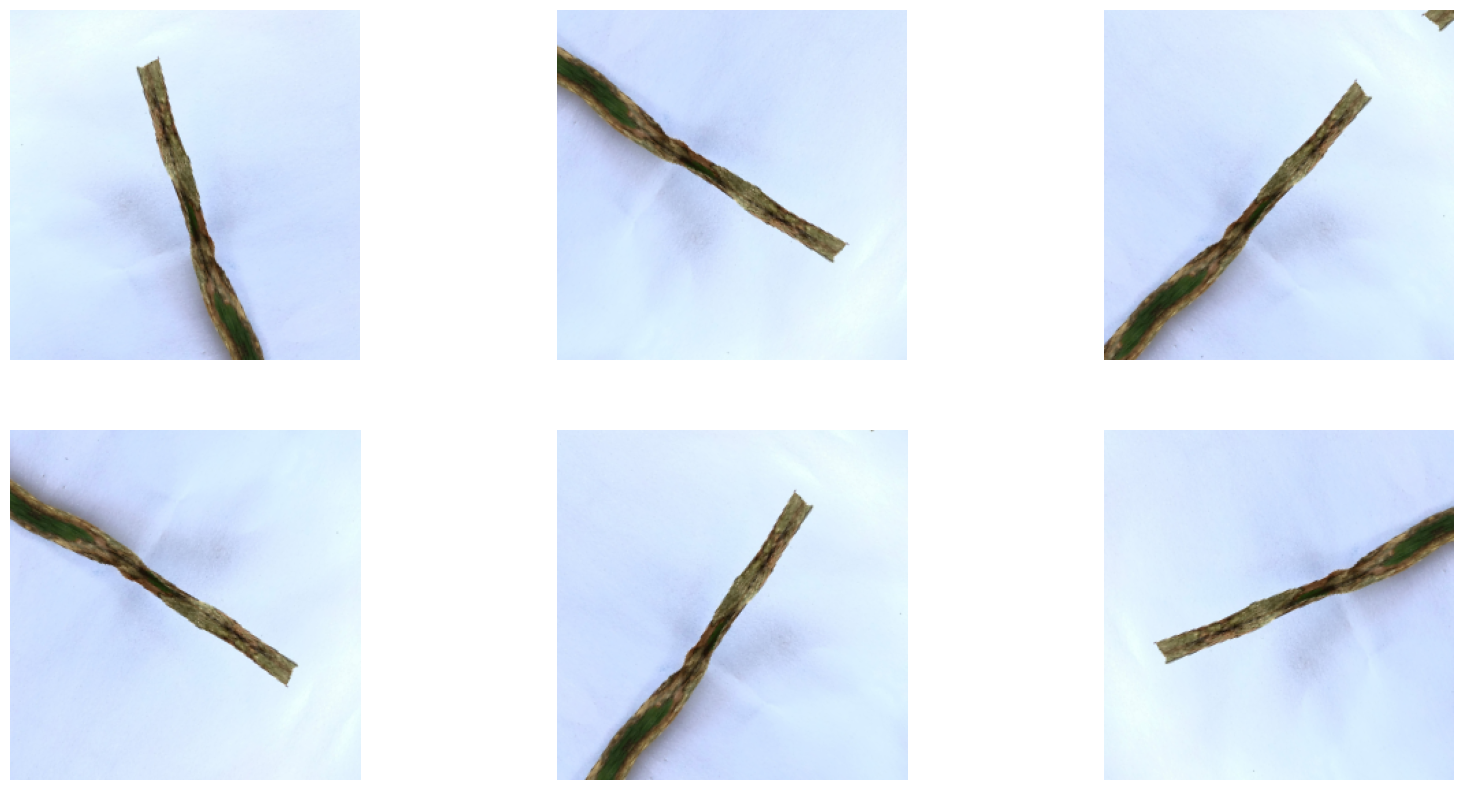

In [16]:
for image, _ in train_data.take(1):
    plt.figure(figsize=(20, 10))
    first_image = image[0]
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

## Preprocessing (Making Pipeline)

In [17]:
tf.random.set_seed(46)

train_datagen = ImageDataGenerator(rescale = 1/255.0)
val_datagen = ImageDataGenerator(rescale = 1/255.0)
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True,
                                             shear_range=0.2,
                                             brightness_range = (0.2, 0.8))

In [18]:
train_data = train_datagen.flow_from_directory(train,
                                               batch_size=20,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle = True,
                                               seed=42)

val_data = val_datagen.flow_from_directory(val,
                                               batch_size=20,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle = False,
                                               seed=42)

train_data_augmented = train_datagen_augmented.flow_from_directory(train,
                                                                   batch_size=20,
                                                                   target_size=(224, 224),
                                                                   class_mode='categorical',
                                                                   shuffle = True,
                                                                   seed=42)

Found 192 images belonging to 3 classes.
Found 72 images belonging to 3 classes.
Found 192 images belonging to 3 classes.


In [19]:
y_train = train_data.classes
y_val = val_data.classes
y_train_augmented = train_data_augmented.classes

In [20]:
print(f'Label Number Each Class on Train Data: {train_data.class_indices}')
print(f'Label Number Each Class on Validation Data: {val_data.class_indices}')
print(f'Label Number Each Class on Train Data Augmented: {train_data_augmented.class_indices}')

Label Number Each Class on Train Data: {'blast': 0, 'blight': 1, 'tungro': 2}
Label Number Each Class on Validation Data: {'blast': 0, 'blight': 1, 'tungro': 2}
Label Number Each Class on Train Data Augmented: {'blast': 0, 'blight': 1, 'tungro': 2}


## Modeling with DenseNet121 as Pre Trained Model

In [21]:
# Model Definition
dense121 = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
dense121.trainable = False

In [22]:
# Model Preparation
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = dense121(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model_dense121 = Model(inputs, outputs)

In [23]:
# compile model
model_dense121.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train model
early_stopping = EarlyStopping(patience=3)
history_dense121 = model_dense121.fit(train_data_augmented,
                    epochs=30,
                    validation_data=val_data,
                    )

Epoch 1/30
10/10 [==============================] - 36s 2s/step - loss: 1.0891 - accuracy: 0.4062 - val_loss: 0.9645 - val_accuracy: 0.5278
Epoch 2/30
10/10 [==============================] - 20s 2s/step - loss: 0.9624 - accuracy: 0.5781 - val_loss: 0.8497 - val_accuracy: 0.6389
Epoch 3/30
10/10 [==============================] - 22s 2s/step - loss: 0.8366 - accuracy: 0.6875 - val_loss: 0.7727 - val_accuracy: 0.6944
Epoch 4/30
10/10 [==============================] - 20s 2s/step - loss: 0.7365 - accuracy: 0.7812 - val_loss: 0.6591 - val_accuracy: 0.8333
Epoch 5/30
10/10 [==============================] - 19s 2s/step - loss: 0.6552 - accuracy: 0.8490 - val_loss: 0.6103 - val_accuracy: 0.7778
Epoch 6/30
10/10 [==============================] - 20s 2s/step - loss: 0.6168 - accuracy: 0.8542 - val_loss: 0.5570 - val_accuracy: 0.8056
Epoch 7/30
10/10 [==============================] - 20s 2s/step - loss: 0.5433 - accuracy: 0.8906 - val_loss: 0.4794 - val_accuracy: 0.9028
Epoch 8/30
10/10 [==

## Model Evaluation

Text(0.5, 1.0, 'Accuracy Curves')

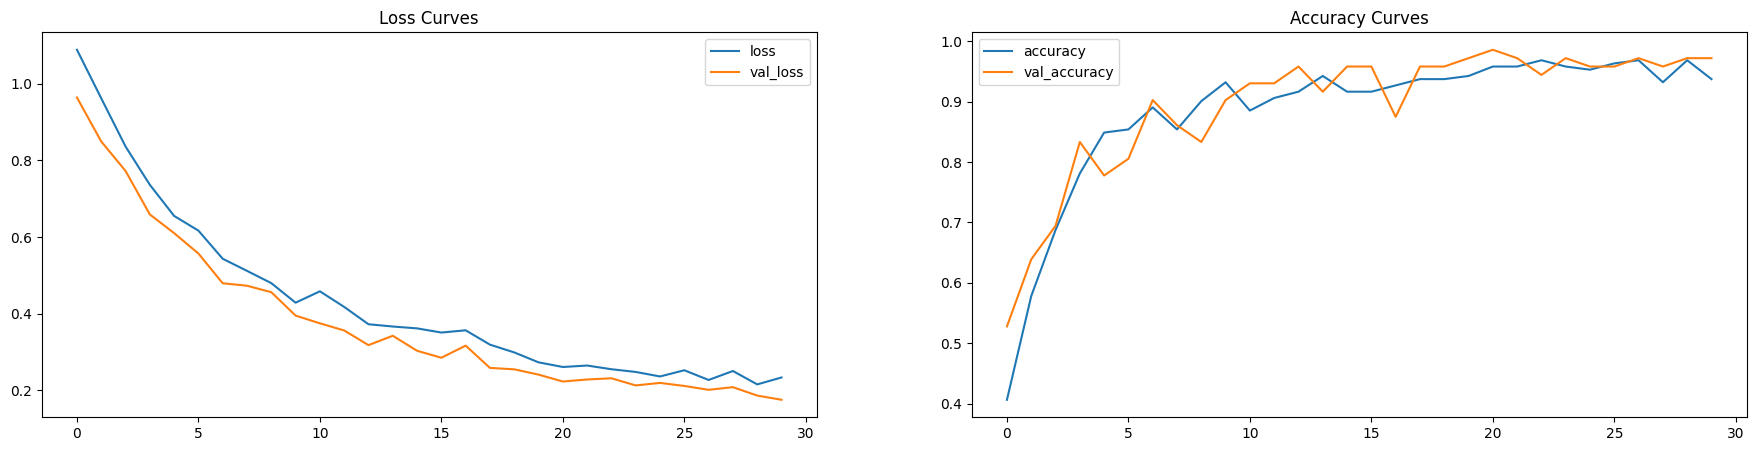

In [24]:
metrics_dense121= pd.DataFrame(history_dense121.history)

figure, ax = plt.subplots (1,2, figsize =(22,5))
metrics_dense121[['loss','val_loss']].plot(ax = ax[0])
ax[0].set_title('Loss Curves')
metrics_dense121[['accuracy','val_accuracy']].plot(ax = ax[1])
ax[1].set_title('Accuracy Curves')  

In [25]:
y_pred=model_dense121.predict(val_data)
y_pred=np.argmax(y_pred,axis=1)

4/4 [==============================] - 9s 1s/step


In [26]:
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.92      0.96        26
           2       0.96      1.00      0.98        23

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



In [27]:
val_data.class_indices

{'blast': 0, 'blight': 1, 'tungro': 2}

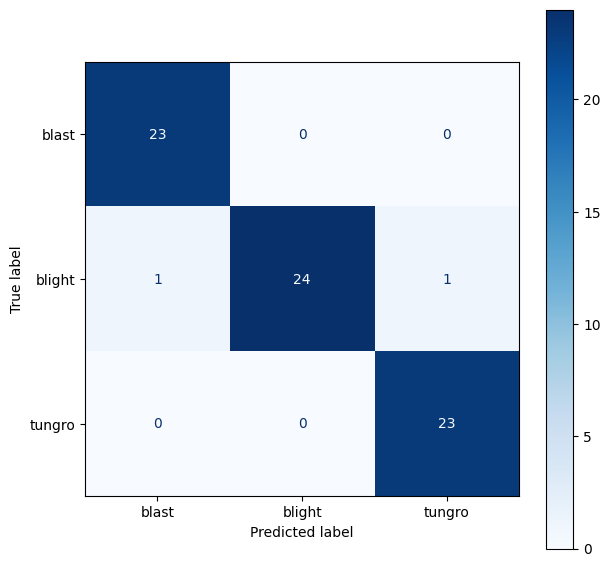

In [28]:
cm = confusion_matrix(y_pred, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Model Inference

### Define Each Label's Name

In [30]:
class_names = ['blast','blight','tungro']

### Blast Disease Prediction

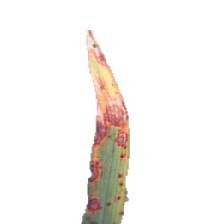

In [32]:
blast1 = load_img('image_for_model_inference/blast_1.jpg', target_size = (224,224))
blast1

In [33]:
blast1=img_to_array(blast1) 
blast1=blast1/255.0
prediction_blast1=np.array(blast1)
prediction_blast1= np.expand_dims(blast1, axis=0)

pred_blast1=model_dense121.predict(prediction_blast1)
value = class_names[np.argmax(pred_blast1)]
print ('Prediction is : {}'.format(value))

1/1 [==============================] - 3s 3s/step
Prediction is : tungro


### Blight Disease Prediction

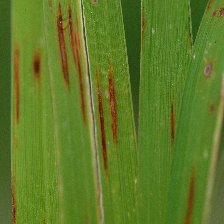

In [ ]:
blight1 = load_img('coba/blight_1.jpg', target_size = (224,224))
blight1

In [ ]:
blight1=img_to_array(blight1) 
blight1=blight1/255.0
prediction_blight1=np.array(blight1)
prediction_blight1= np.expand_dims(blight1, axis=0)

pred_blight1=model_dense121.predict(prediction_blight1)
value = class_names[np.argmax(pred_blight1)]
print ('Prediction is : {}'.format(value))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediction is : blight


### Tungro Disease Prediction

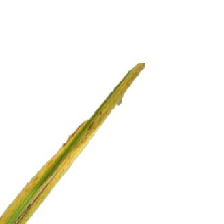

In [ ]:
tungro1 = load_img('coba/tungro_1.jpg', target_size = (224,224))
tungro1

In [ ]:
tungro1=img_to_array(tungro1) 
tungro1=tungro1/255.0
prediction_tungro1=np.array(tungro1)
prediction_tungro1= np.expand_dims(tungro1, axis=0)

In [ ]:
pred_tungro1=model_dense121.predict(prediction_tungro1)
value = class_names[np.argmax(pred_tungro1)]
print ('Prediction is : {}'.format(value))

Prediction is : tungro


## Save Model with Pretrained Dense121 Model

In [35]:
tf.keras.models.save_model(
    model_dense121, 'rice_disease_model.hdf5')


In [ ]:
def load_model():
        model_path = r'..\rice-disease-detection\\models\\rice_disease_model.hdf5'
        # model = tf.keras.models.load_model('rice_disease_model.h5')
        model = tf.keras.models.load_model(model_path)
        return model

In [ ]:
model.compile

<bound method Trainer.compile of <Functional name=functional_1, built=True>>

In [ ]:
model_path = '../rice-disease-detection/models/rice_disease_model.hdf5'
        # model_path = 'rice_disease_model.hdf5'
    
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")
